# MNIST Test

WNixalo 2018/5/19-20;25

Making sure I have a working baseline for the MNIST dataset. PyTorch version: `0.3.1.post2`

- For a walkthrough on converting binary IDX files to NumPy arrays, see [idx-to-numpy.ipynb](https://github.com/WNoxchi/Kaukasos/blob/master/research/idx-to-numpy.ipynb)

- For a walkthrough debugging several issues with dataloading, see [mnist-dataloader-issue.ipynb](https://github.com/WNoxchi/Kaukasos/blob/master/research/mnist-dataloader-issue.ipynb)

---

## Imports

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from pathlib import Path
import os
import struct   # for IDX conversion
import gzip     # for IDX conversion
from urllib.request import urlretrieve # for IDX conversion

from fastai.conv_learner import * # if you want to use fastai Learner

In [3]:
PATH = Path('data/mnist')

In [4]:
bs = 64
sz = 28

## 1. Data

### 1.1 PyTorch method:

The basic method for creating a DataLoader in PyTorch. Adapted from [their tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html?highlight=mnist#) and an older [notebook](https://github.com/WNoxchi/Kaukasos/blob/master/PyTorch/practice-mnist.ipynb). 
- **NOTE** the [normalization values are largely arbitrary](https://discuss.pytorch.org/t/normalization-in-the-mnist-example/457/7?u=wnixalo).

In [5]:
# torchvision datasets are PIL.Image images of range [0,1]. Must trsfm them 
# to Tensors of normalized range [-1,1]
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

In [150]:
# see: https://gist.github.com/kevinzakka/d33bf8d6c7f06a9d8c76d97a7879f5cb
# frm: https://github.com/pytorch/pytorch/issues/1106

trainset = torchvision.datasets.MNIST(root=PATH, train=True, download=True,
                                   transform=transform)
validset = torchvision.datasets.MNIST(root=PATH, train=True, download=True,
                                   transform=transform)
testset  = torchvision.datasets.MNIST(root=PATH, train=False, download=True,
                                   transform=transform)
p_val = 0.15
n_val = int(p_val * len(trainset))
idxs  = np.arange(len(trainset))
np.random.shuffle(idxs)
train_idxs, valid_idxs = idxs[n_val:], idxs[:n_val]
train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_idxs)
valid_sampler = torch.utils.data.sampler.SequentialSampler(valid_idxs)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=bs,
                                          sampler=train_sampler, num_workers=2)
validloader = torch.utils.data.DataLoader(validset, batch_size=bs,
                                          sampler=valid_sampler, num_workers=2)
testloader  = torch.utils.data.DataLoader(testset, batch_size=bs, num_workers=2)

In [7]:
classes = [str(i) for i in range(10)]; classes

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

#### 1.1.1 Aside: DataLoaders – PyTorch & fastai:

- See [mnist-dataloader-issue.ipynb](https://github.com/WNoxchi/Kaukasos/blob/master/research/mnist-dataloader-issue.ipynb) for an in depth dive.

The FastAI DataLoader shares some similarities in construction with the PyTorch one. The logic defining pytorch's DataLoader [in the PyTorch source code](https://pytorch.org/docs/master/_modules/torch/utils/data/dataloader.html#DataLoader):
```
if batch_sampler is None:
    if sampler is None:
        if shuffle:
            sampler = RandomSampler(dataset)
        else:
            sampler = SequentialSampler(dataset)
    batch_sampler = BatchSampler(sampler, batch_size, drop_last)
```
is the same as [that in fast.ai's](https://github.com/fastai/fastai/blob/master/fastai/dataloader.py#L24-43)

```
if batch_sampler is None:
    if sampler is None:
        sampler = RandomSampler(dataset) if shuffle else SequentialSampler(dataset)
    batch_sampler = BatchSampler(sampler, batch_size, drop_last)
```

So now I'm not confused about not using a batch sampler when building a pytorch dataloader, although I see one in fastai's DataLoader –– that's because pytorch does it too.

### 1.2 Custom Method (for Fast AI Model Data)

This loads and converts the MNIST IDX files into NumPy arrays. For MNIST data this looks to be about 45 MB for the images. This way allows for easy use of FastAI's ModelData class, and thus its (extremely useful) Learner abstraction and all other capabilities that come with it. The arrays can be loaded via: `ImageClassifierData.from_arrays(..)`

In [8]:
def download_mnist(path=Path('data/mnist')):
    os.makedirs(path, exist_ok=True)
    urls = ['http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz',
            'http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz',
            'http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz',
            'http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz',]
    for url in urls:
        fname = url.split('/')[-1]
        if not os.path.exists(path/fname): urlretrieve(url, path/fname)

def read_IDX(fname):
    """see: https://gist.github.com/tylerneylon/ce60e8a06e7506ac45788443f7269e40"""
    with gzip.open(fname) as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

In [174]:
fnames = [o for o in os.listdir(PATH) if 'ubyte.gz' in o] # could just use glob
fnames

['t10k-images-idx3-ubyte.gz',
 'train-images-idx3-ubyte.gz',
 'train-labels-idx1-ubyte.gz',
 't10k-labels-idx1-ubyte.gz']

In [175]:
# thanks to: https://stackoverflow.com/a/14849322
trn_x_idx = [i for i,s in enumerate(fnames) if 'train-imag' in s][0]
trn_y_idx = [i for i,s in enumerate(fnames) if 'train-lab' in s][0]
# test data:
tst_x_idx = [i for i,s in enumerate(fnames) if 't10k-imag' in s][0]
tst_y_idx = [i for i,s in enumerate(fnames) if 't10k-lab' in s][0]

In [176]:
# load entire IDX files into memory as ndarrays
train_x_array = read_IDX(PATH/fnames[trn_x_idx])
train_y_array = read_IDX(PATH/fnames[trn_y_idx])
# test data:
test_x_array  = read_IDX(PATH/fnames[tst_x_idx])
test_y_array  = read_IDX(PATH/fnames[tst_y_idx])

In [177]:
# size of numpy arrays in MBs
train_x_array.nbytes / 2**20, train_y_array.nbytes / 2**20

(44.86083984375, 0.057220458984375)

### 1.3 Fast AI Model Data object

`inception_stats` have the same Normalization that the pytorch transform above uses for its dataloader. I don't do any data augmentation besides that normalization. I also use the same train/val indices from the pytorch dataloader – to ensure my pytorch model and fastai learner are working on the same data.

Additionally in order to use pretrained models I'm going to concatenate the dataset to have 3 channels instead of 1 by copying dimensions. Another option is to forego a pretrained model and use a fresh resnet set to have only 1 input channel.

In [178]:
tfms = tfms_from_stats(inception_stats, sz=sz)
# `inception_stats` are: ([0.5,0.5,0.5],[0.5,0.5,0.5])
# see: https://github.com/fastai/fastai/blob/master/fastai/transforms.py#L695

In [179]:
# using same trn/val indices as pytorch dataloader
valid_x_array, valid_y_array = train_x_array[valid_idxs], train_y_array[valid_idxs]
train_x_array, train_y_array = train_x_array[train_idxs], train_y_array[train_idxs]

In [180]:
# stack dims for 3 channels
train_x_array = np.stack((train_x_array, train_x_array, train_x_array), axis=-1)
valid_x_array = np.stack((valid_x_array, valid_x_array, valid_x_array), axis=-1)
test_x_array  = np.stack((test_x_array, test_x_array, test_x_array), axis=-1)
# convert labels to np.int8
train_y_array = train_y_array.astype(np.int8)
valid_y_array = valid_y_array.astype(np.int8)
test_y_array  = test_y_array.astype(np.int8)

In [181]:
model_data = ImageClassifierData.from_arrays(PATH, 
    (train_x_array, train_y_array), (valid_x_array, valid_y_array),
    bs=bs, tfms=tfms, num_workers=2, test=(test_x_array, test_y_array))

## 2. Architecture

I want to have a "solid" simple ConvNet to use throughout these experiments. This model will include a large field-of-view input conv layer followed by several conv layers. Each conv layer uses BatchNorm and Leaky ReLU (I don't know if this is better than ReLU, but it *sounds* like a good'ish idea to me). The model's head uses an AdaptiveConcat Pooling layer (Fast AI invention that concatenates two adaptive average and max pooling layers) leading to a Linear layer. This model doesn't use dropout (I'll add that if it looks like it needs it).

In [19]:
class AdaptiveConcatPool2d(nn.Module):
    """fast.ai, see: https://github.com/fastai/fastai/tree/master/fastai/layers.py"""
    def __init__(self, sz=None):
        super().__init__()
        sz = sz or (1,1)
        self.ap = torch.nn.AdaptiveAvgPool2d(sz)
        self.mp = torch.nn.AdaptiveAvgPool2d(sz)
    def forward(self, x):
        return torch.cat([self.mp(x), self.ap(x)], 1)
    
class Flatten(nn.Module):
    """fast.ai, see: https://github.com/fastai/fastai/tree/master/fastai/layers.py"""
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return x.view(x.size(0), -1)

In [20]:
class ConvBNLayer(nn.Module):
    """conv layer with batchnorm"""
    def __init__(self, ch_in, ch_out, kernel_size=3, stride=1, padding=0):
        super().__init__()
        self.conv  = nn.Conv2d(ch_in, ch_out, kernel_size=kernel_size, stride=stride)
        self.bn    = nn.BatchNorm2d(ch_out, momentum=0.1) # mom at default 0.1
        self.lrelu = nn.LeakyReLU(0.01, inplace=True)     # neg slope at default 0.01
    def forward(self, x): return self.lrelu(self.bn(self.conv(x)))

class ConvNet(nn.Module):
    # see ref: https://github.com/fastai/fastai/blob/master/fastai/models/darknet.py
    def __init__(self, ch_in=1):
        super().__init__()
        self.conv0   = ConvBNLayer(ch_in, 16, kernel_size=7, stride=1, padding=2) # large FoV Conv
        self.conv1   = ConvBNLayer(16, 32)
        self.conv2   = ConvBNLayer(32, 64)
        self.conv3   = ConvBNLayer(64, 128)
        self.neck    = nn.Sequential(*[AdaptiveConcatPool2d(1), Flatten()])
        self.head    = nn.Sequential(*[nn.BatchNorm2d(256), 
                                      nn.Dropout(p=0.25),
                                      nn.Linear(256, 10)])        
    def forward(self, x):
        x = self.conv0(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.neck(x)
        x = self.head(x)
        return F.log_softmax(x, dim=-1)

In [21]:
convnet = ConvNet()

#### 2.0.1 Aside: Discovering AdaptiveConcatPool doubles input tensor length

In [216]:
x,y = next(iter(trainloader))
x,y = Variable(x), Variable(y)
convnet(x)

> <ipython-input-204-3df4356516d4>(24)forward()
-> x = self.conv0(x)
(Pdb) n
> <ipython-input-204-3df4356516d4>(25)forward()
-> x = self.conv1(x)
(Pdb) n
> <ipython-input-204-3df4356516d4>(26)forward()
-> x = self.conv2(x)
(Pdb) n
> <ipython-input-204-3df4356516d4>(27)forward()
-> x = self.conv3(x)
(Pdb) n
> <ipython-input-204-3df4356516d4>(28)forward()
-> x = self.neck(x)
(Pdb) x.shape # sanity check
torch.Size([64, 128, 16, 16])
(Pdb) AdaptiveConcatPool2d(1)(x).shape
torch.Size([64, 256, 1, 1])
(Pdb) q


BdbQuit: 

### 2.1 Fast AI Learner

I'll use two fast.ai learners: the basic convnet defined above that the pytorch model will also use, and a resnet18. I'll also use an ImageNet-pretrained resnet18 to see if that helps at all. If `.pretrained` is not called, you will need to either use `ConvnetBuilder` or define a custom head yourself. **NOTE** also that the standard pytorch ResNet model has a 7x7 ouput pooling layer by default, which may restrict your model's performance if it's not replaced (such as with ConvnetBuilder).

The non-pretrained learner's will need their conv layers unfrozen to train them.

In [22]:
model_data.c, model_data.is_multi, model_data.is_reg

(10, False, False)

In [182]:
resnet_model = ConvnetBuilder(resnet18, model_data.c, model_data.is_multi, model_data.is_reg, pretrained=False)

resnet_learner = ConvLearner(model_data, resnet_model)
custom_learner = ConvLearner.from_model_data(ConvNet(ch_in=3), model_data)
pt_res_learner = ConvLearner.pretrained(resnet18, model_data)

#### 2.1.1 Aside: Layers

Again, the learners' conv layers are initially frozen:

In [63]:
True in [[layer.trainable for layer in layer_group] for layer_group in resnet_learner.get_layer_groups()]

False

By default only the 'head' classification layer is trainable:

In [64]:
[[layer.trainable for layer in layer_group] for layer_group in resnet_learner.get_layer_groups()]

[[False, False, False, False, False, False],
 [False, False, False, False],
 [True, True, True, True, True, True, True, True]]

Construct the custom learner with ConvnetBuilder in order to make it's layers iterable:

In [66]:
[[layer.trainable for layer in layer_group] for layer_group in custom_learner.get_layer_groups()]

TypeError: 'ConvBNLayer' object is not iterable

In [73]:
custom_learner.models

In [74]:
resnet_learner.models

In [78]:
# custom_learner

In [76]:
# resnet_learner

In [77]:
# pt_res_learner

#### 2.1.2 Recap: Models

I'll be comparing 4 models:
1. **`convnet`** a 1-input channel custom CNN trained in straight PyTorch
2. **`custom_learner`** a 3-input channel custom CNN trained with Fast AI
3. **`resnet_learner`** a 3-input channel fresh ResNet18 trained with Fast AI
4. **`pt_res_learner`** a 3-input channel pretrained (ImageNet) ResNet18 trained with Fast AI.

Perhaps it'd be a good idea to replace the fresh ResNet18's input layer with a 1-channel input to compare it directly to the custom CNN. That's for a future run if I or anyone chooses to do so.

## 3. Loss Function

[`torch.nn.CrossEntropyLoss`](https://github.com/pytorch/pytorch/blob/master/torch/nn/modules/loss.py#L701)

Do `nn.functional.` loss functions go in the architecture, and `nn.` loss functions become criterion? [Huh, interesting. It calls `nn.functional.`](https://github.com/pytorch/pytorch/blob/master/torch/nn/modules/loss.py#L778).

In [24]:
criterion = torch.nn.NLLLoss() # log_softmax already in arch; nll(log_softmax) <=> CE
optimizer = torch.optim.SGD(convnet.parameters(), lr=0.01, momentum=0.9)

The Fast.ai Learners:

In [25]:
custom_learner.crit

<function torch.nn.functional.nll_loss(input, target, weight=None, size_average=True, ignore_index=-100, reduce=True)>

In [26]:
resnet_learner.crit

<function torch.nn.functional.nll_loss(input, target, weight=None, size_average=True, ignore_index=-100, reduce=True)>

In [27]:
pt_res_learner.crit

<function torch.nn.functional.nll_loss(input, target, weight=None, size_average=True, ignore_index=-100, reduce=True)>

## 4. Training

As far as I know, training in base PyTorch is tedious, so I'll do a sanity-check of it first, then do all my training with Fast AI. See ref: §4: Training or §9.1: Train ConvNet & ConvNetMod in [this notebook](https://github.com/WNoxchi/Kaukasos/blob/master/PyTorch/practice-mnist.ipynb).

There are ways to implement learning-rate scheduling and other advanced techniques in PyTorch – but by that point unless you're doing it for practice or testing a new module: *that's what Fast.AI is for*.

### 4.1 base PyTorch

In [41]:
len(trainloader)

797

There are more improvements to doing train / valid phases – including learning rate scheduling and automatically saving best weights (see: [pytorch tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html?highlight=dataloaders#load-data)) – but that's what fast.ai's for. I'll practice those in the future. Also since the FastAI library is pending an update to PyTorch 0.4, `torch.set_grad_enabled` can't be used for inference mode. Instead I follow the advice on this [pytorch forum thread](https://discuss.pytorch.org/t/resolved-validation-loss/3501). For now:

In [29]:
def train(model=None, crit=None, trainloader=None, valloader=None, num_epochs=1, verbose=True):
    # if verbose:
    #     displays = 5
    #     display_step = max(len(dataloader) // displays, 1)
    t0 = time.time()
    
    dataloaders = {'train':trainloader}
    if valloader: dataloaders['valid'] = valloader
    
    # epoch w/ train & val phases
    for epoch in range(num_epochs): 
        print(f'Epoch {epoch+1}/{num_epochs}\n{"-"*10}')
        
        for phase in dataloaders:
            running_loss = 0.0
            running_correct = 0
            
            for i,datum in enumerate(dataloaders[phase]):
                inputs, labels = datum
                inputs, labels = torch.autograd.Variable(inputs), torch.autograd.Variable(labels)

                # zero param gradients
                optimizer.zero_grad()

                # (forward) track history if train
                # with torch.set_grad_enabled(phase=='train'): # pytorch >= 0.4
                if phase == 'valid':     # pytorch 3.1 #
                    inputs.volatile=True               #
                    labels.volatile=True               #
                outputs = model(inputs)                #
                loss    = crit(outputs, labels)        #
                _, preds= torch.max(outputs, 1) # for accuracy metric
                                                       #
                # backward & optimize if train         #
                if phase == 'train':                   #
                    loss.backward()                    #
                    optimizer.step()                   # indent for pytorch >= 0.4

                # stats
                running_loss += loss.data[0]
                running_correct += torch.sum(preds == V(labels.data)) # wrap in V; pytorch 3.1
                    
            epoch_loss = running_loss / len(dataloaders[phase])
#             if phase == 'valid': pdb.set_trace()
            epoch_acc  = float(running_correct.double() / len(dataloaders[phase])) # ? pytorch 3.1 reqs float conversion?
#             pdb.set_trace()
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
                
    time_elapsed = time.time() - t0
    print(f'Training Time {num_epochs} Epochs: {time_elapsed:.3f}s')

Manual PyTorch train / val training phases. See: [pytorch tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html?highlight=validation#training-the-model)

*(forward) track history only if in train:*
```
with torch.set_grad_enabled(False):
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)
```
*backward + optimize only if in training phase*
```
    if phase == 'train':
        loss.backward()
        optimizer.step()
```

**NOTE**: I think I'm doing something wrong with the validation phase. [Saving](https://discuss.pytorch.org/t/saving-and-loading-a-model-in-pytorch/2610/7?u=wnixalo). [PyTorch Docs on Saving](https://pytorch.org/docs/master/notes/serialization.html).

In [30]:
train(model=convnet, crit=criterion, trainloader=trainloader, valloader=validloader)

Epoch 1/1
----------
train Loss: 0.1932 Acc: 0.0540
valid Loss: 0.0766 Acc: 0.7518
Training Time 1 Epochs: 230.497s


In [34]:
torch.save(convnet.state_dict(), 'convnet.pth')

In [42]:
convnet.load_state_dict(torch.load('convnet.pth'))

### 4.2 with Fast AI

#### 4.2.1 Finding Learning Rates

To keep things simple, I won't be using [1-Cycle](http://forums.fast.ai/t/the-1cycle-policy-an-experiment-that-investigate-super-convergence-phenomenon-described-in-leslie-smiths-research/14737), [Progressive Resizing](http://www.fast.ai/2018/04/30/dawnbench-fastai/#imagenet), or much in the way of [Cyclical Learning Rates](https://arxiv.org/abs/1506.01186). That could be a topic for later runs.

In [62]:
model_data.trn_ds.get1item(0)[1].dtype

dtype('int8')

 84%|████████▍ | 669/797 [03:23<00:38,  3.29it/s, loss=1.22] 

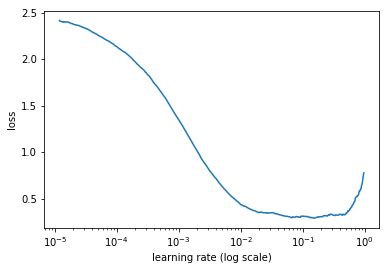

In [65]:
custom_learner.lr_find()
custom_learner.sched.plot()

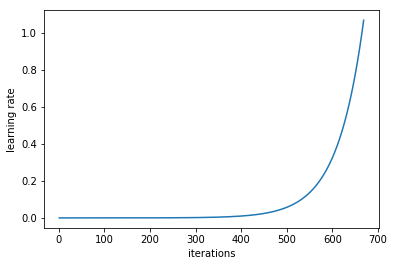

In [66]:
custom_learner.sched.plot_lr()

 85%|████████▍ | 675/797 [03:55<00:42,  2.86it/s, loss=1.28] 

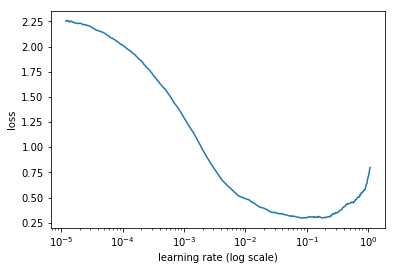

In [183]:
custom_learner.lr_find()
custom_learner.sched.plot()

In [67]:
# next(iter(model_data.get_dl(model_data.trn_ds, False)))

In [69]:
resnet_learner.lr_find()
resnet_learner.sched.plot_lr()

In [ ]:
pt_res_learner.lr_find()
pt_res_learner.sched.plot_lr()

#### 4.2.2 `custom_learner`

#### 4.2.3 `resnet_learner`

#### 4.2.4 `pt_res_learner`

## 5. Testing

#### 5.0.1 PyTorch convnet

In [163]:
x,y = next(iter(testloader)) # shape: ([64,1,28,28]; [64])
out = convnet(V(x))          # shape: ([64, 10])

In [164]:
_, preds = torch.max(out.data, 1)

In [165]:
list(zip(preds[:9], y[:9]))

[(7, 7), (2, 2), (1, 1), (0, 0), (4, 4), (1, 1), (4, 4), (9, 9), (2, 5)]

Cool, even with that little training it's able to get a lot right.

In [134]:
def test_pytorch(model, dataloader):
    """evaluation script. Returns tuple: (list of predictions, ratio correct)"""
    correct = 0
    total = 0
    
    predictions = []

    for batch in dataloader:
        images, labels = batch   ## could also go w: testloader.dataset.test_labels
        outputs  = convnet(Variable(images))
        _, preds = torch.max(outputs.data, 1)
        total   += labels.size(0)
        correct += (preds == labels).sum()
        
        predictions.extend(preds)
        
    return predictions, correct/total

In [161]:
preds, test_acc = test_pytorch(convnet, testloader)
test_acc

0.981

98% accuracy on test set. Just checking:

In [162]:
_,y = next(iter(testloader))
list(zip(preds[:9], y[:9]))

[(7, 7), (2, 2), (1, 1), (0, 0), (4, 4), (1, 1), (4, 4), (9, 9), (2, 5)]

#### 5.0.2 `custom_learner`

##### Aside: (untrained) `custom_learner` Sanity Checks:

In [195]:
## 2-3 ways to do the same thing
# log_preds_dl = custom_learner.predict_dl(testloader) # make sure num channels correct before trying this; havent tested
log_preds_dl = custom_learner.predict_dl(model_data.test_dl)
log_preds = custom_learner.predict(is_test=True)

I had some confusion. You *do* take the max as the top prediction; to get the actual probabilities, since it's a log softmax ouput, you exponentiate. 

In [196]:
log_preds_dl.shape, log_preds.shape # same shape

((10000, 10), (10000, 10))

In [199]:
np.unique(log_preds_dl == log_preds) # same values

array([ True])


 7
 2
 1
⋮ 
 4
 5
 6
[torch.LongTensor of size 10000]

In [236]:
np.equal(testloader.dataset.test_labels, np.argmax(log_preds, axis=1)).sum() / len(testloader.dataset.test_labels)

0.0892

Untrained CNN gets sub-random (< 10%) accuracy. No surprise, it only ever guesses '5', and sometimes '4':

In [242]:
set(np.argmax(log_preds, axis=1)), np.argmax(log_preds, axis=1)

({4, 5}, array([5, 5, 5, ..., 5, 5, 5]))

#### 5.0.3 `resnet_learner`

#### 5.0.4 `pt_res_learner`

## 6. Comparisons